# missing data interpolation (not gridfilling)

statistics is the answer to everything

### potential shenanigans

"Several techniques have been used to fill the gaps in either the UWLS or OI derived total vector maps.

These are implemented using covariance derived from normal mode analysis (Lipphardt et al. 2000), open-boundary modal analysis (OMA) (Kaplan and Lekien 2007), and empirical orthogonal function (EOF) analysis (Beckers and Rixen 2003; Alvera-Azcárate et al. 2005); and using idealized or smoothed observed covariance (Davis 1985)."

- normal mode analysis
- open-boundary modal analysis (OMA)
- empirical orthogonal function analysis (EOF)
- use idealized/smoothed observed covariance

---

### other ideas

DINEOF (could only find an implementation in R)

to be honest I don't understand any of these methods but they look cool

### currently implemented:

rip data straight from the 6 km data for areas where data is considered missing in the 2 km data

In [1]:
%matplotlib inline

In [2]:
import time
import xarray as xr
import numpy as np
from parcels import FieldSet
from datetime import timedelta, datetime

### netcdf files

these particular regions were selected because they covered the same-ish region

if things get messy you might have to check the netcdf files individually

In [3]:
# 6 km res files
category6km = "west_coast_6km_hourly"
filename6km = "west_coast_6km_hourly_netcdfs/west_coast_6km_hourly_region0.nc"

# 2 km res files
category2km = "west_coast_2km_hourly"
filename2km = "west_coast_2km_hourly_netcdfs/west_coast_2km_hourly_region0.nc"

In [4]:
data_6km = xr.open_dataset(filename6km)
data_6km

<xarray.Dataset>
Dimensions:                (lat: 268, lon: 177, nv: 2, time: 169, time_1: 1)
Coordinates:
  * lat                    (lat) float32 32.24578 32.29972 ... 46.59382 46.64776
  * lon                    (lon) float32 -126.79947 -126.73701 ... -115.805565
  * time                   (time) datetime64[ns] 2020-06-16T21:00:00 ... 2020-06-23T21:00:00
    time_run               (time) datetime64[ns] ...
Dimensions without coordinates: nv, time_1
Data variables:
    time_bnds              (time_1, nv) int32 ...
    depth_bnds             (nv) float32 ...
    wgs84                  int8 ...
    processing_parameters  int8 ...
    radial_metadata        int8 ...
    depth                  float32 ...
    time_offset            (time) datetime64[ns] ...
    u                      (time, lat, lon) float32 ...
    v                      (time, lat, lon) float32 ...
    dopx                   (time, lat, lon) float32 ...
    dopy                   (time, lat, lon) float32 ...
    hdop                   (time, lat, lon) float32 ...
    number_of_sites        (time, lat, lon) float32 ...
    number_of_radials      (time, lat, lon) float32 ...
Attributes:
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202007011900siohfruwlsrtvuswc6km
    date_created:              2020-07-01T21:52:38Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. We...
    summary:                   Surface ocean velocities estimated from HF-Rad...
    instrument:                Earth Remote Sensing Instruments, Active Remot...
    keywords:                  Earth Science, Oceans, Sea Surface, Coastal Pr...
    geospatial_lat_min:        30.25
    geospatial_lat_max:        49.99204
    geospatial_lon_min:        -130.36
    geospatial_lon_max:        -115.805565
    processing_level:          Near real-time dataset with automated data acq...
    history:                   2020-07-01T20:23:18Z hfrnet rtvMergeData: Savi...
    references:                Terrill, E. et al., 2006. Data Management and ...
    institution:               Coastal Observing Research and Development Cen...
    creator_type:              group
    creator_name:              HFRNet Administrators
    creator_email:             hfrnet.administrators@sio.ucsd.edu
    creator_url:               http://cordc.ucsd.edu/projects/mapping/
    naming_authority:          edu.ucsd.cordc
    standard_name_vocabulary:  CF Standard Name Table, Version 51
    keywords_vocabulary:       Global Change Master Directory (GCMD) Keywords...
    instrument_vocabulary:     Global Change Master Directory (GCMD) Keywords...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_West_Coast_6km_Resolutio...

In [5]:
data_2km = xr.open_dataset(filename2km)
data_2km

<xarray.Dataset>
Dimensions:                (lat: 186, lon: 249, nv: 2, time: 169, time_1: 1)
Coordinates:
  * lat                    (lat) float32 32.2278 32.24578 ... 35.53612 35.5541
  * lon                    (lon) float32 -121.84389 -121.82306 ... -116.68008
  * time                   (time) datetime64[ns] 2020-06-16T21:00:00 ... 2020-06-23T21:00:00
    time_run               (time) datetime64[ns] ...
Dimensions without coordinates: nv, time_1
Data variables:
    time_bnds              (time_1, nv) int32 ...
    depth_bnds             (nv) float32 ...
    wgs84                  int8 ...
    processing_parameters  int8 ...
    radial_metadata        int8 ...
    depth                  float32 ...
    time_offset            (time) datetime64[ns] ...
    u                      (time, lat, lon) float32 ...
    v                      (time, lat, lon) float32 ...
    dopx                   (time, lat, lon) float32 ...
    dopy                   (time, lat, lon) float32 ...
    hdop                   (time, lat, lon) float32 ...
    number_of_sites        (time, lat, lon) float32 ...
    number_of_radials      (time, lat, lon) float32 ...
Attributes:
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202007011900siohfruwlsrtvuswc2km
    date_created:              2020-07-01T21:20:25Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. We...
    summary:                   Surface ocean velocities estimated from HF-Rad...
    instrument:                Earth Remote Sensing Instruments, Active Remot...
    keywords:                  Earth Science, Oceans, Sea Surface, Coastal Pr...
    geospatial_lat_min:        30.25
    geospatial_lat_max:        49.99204
    geospatial_lon_min:        -130.36
    geospatial_lon_max:        -115.805565
    processing_level:          Near real-time dataset with automated data acq...
    history:                   2020-07-01T20:20:41Z hfrnet rtvMergeData: Savi...
    references:                Terrill, E. et al., 2006. Data Management and ...
    institution:               Coastal Observing Research and Development Cen...
    creator_type:              group
    creator_name:              HFRNet Administrators
    creator_email:             hfrnet.administrators@sio.ucsd.edu
    creator_url:               http://cordc.ucsd.edu/projects/mapping/
    naming_authority:          edu.ucsd.cordc
    standard_name_vocabulary:  CF Standard Name Table, Version 51
    keywords_vocabulary:       Global Change Master Directory (GCMD) Keywords...
    instrument_vocabulary:     Global Change Master Directory (GCMD) Keywords...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_West_Coast_2km_Resolutio...

### domains

so fun fact the 2 km region actually has part of its domain outside the region of the 6 km data

luckily none of the data we care about is in that part of the domain

if there does happen to mysteriously be some out of domain problem, that's why

the 6 km data and 2 km data should also have the same timeframe and the 2 km data lat/lon domain should *mostly* be inside the 6 km lat/lon domain

In [6]:
# dom_2km_reg0 = {"W":-121.84388732910156,"E":-116.6800765991211,"S":32.22779846191406,"N":35.17652130126953}
dom_2km_reg0 = {"W":-121.84388732910156,"E":-116.6800765991211,"S":32.24578094482422,"N":35.17652130126953}

flat mesh so the velocity data isn't converted when retrieving interpolated velocities

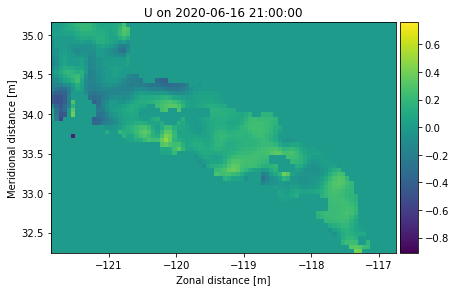

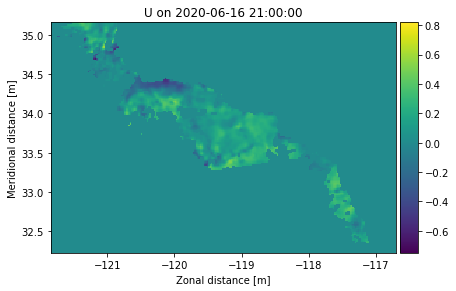

In [7]:
fs_6km = FieldSet.from_xarray_dataset(data_6km.copy(deep=True), dict(U="u",V="v"), dict(lat="lat",lon="lon",time="time"), mesh='flat')
fs_2km = FieldSet.from_xarray_dataset(data_2km.copy(deep=True), dict(U="u",V="v"), dict(lat="lat",lon="lon",time="time"), mesh='flat')

fs_6km.U.show(show_time=0,domain=dom_2km_reg0)
fs_2km.U.show(show_time=0,domain=dom_2km_reg0)

## nan values and parcels

note that when this xarray Dataset is passed into parcels, all the nan values change to 0 and the mask generation won't work anymore

so the Dataset is copied for use with the FieldSet instead

In [8]:
def generate_mask(data):
    # data should be in shape (time, lat, lon)
    # invert the mask so I can actually index a single coordinate by time
    mask = np.zeros(data.shape, dtype=bool).T
    # could probably use more numpy indexing for more speed
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            point = data.T[j][i]
            # lat lon point has data
            nan_vals = np.isnan(point)
            if not nan_vals.all():
                mask[j][i][:] = np.where(nan_vals.flatten(), 1, 0)
    return mask.T

In [9]:
invalid_2km = generate_mask(data_2km["u"].values)
num_invalid = invalid_2km.sum()

In [10]:
print(f"total invalid values on original data: {num_invalid}")

total invalid values on original data: 487261


In [11]:
lat_6km = data_6km["lat"].values
lon_6km = data_6km["lon"].values

lat_2km = data_2km["lat"].values
lon_2km = data_2km["lon"].values

invalid_pos = np.where(invalid_2km)

time_diff = np.diff(fs_6km.U.grid.time)[0]

### use of Parcels Field for interpolation

indexing Field values goes [time, depth, lat, lon]

Field also does interpolation automatically when indexing values between it's coordinate values

TODO: check if the coordinate retrieved from the 6 km data even exists

parcels just sets every null value to 0 so there needs to be a check with the Dataset

### note

the nan check and dataset indexing triples the runtime of the check

I'm currently using the xarray Dataset selection because it has a nearest neighbor lookup when indexing

https://stackoverflow.com/questions/12923586/nearest-neighbor-search-python

now I'm not sure if xarray uses the same method, but considering how much slower it is to index a Dataset, it's worth a try

edit: it's much much much faster

In [12]:
import scipy.spatial

lat_6km_ckdtree = scipy.spatial.cKDTree(np.array([lat_6km]).T)
lon_6km_ckdtree = scipy.spatial.cKDTree(np.array([lon_6km]).T)

In [13]:
data_6km_u_ref = data_6km["u"].values
data_6km_v_ref = data_6km["v"].values

def get_6km_interped_u(i):
    t = invalid_pos[0][i]
    lat = lat_2km[invalid_pos[1][i]]
    lon = lon_2km[invalid_pos[2][i]]
    if np.isnan(data_6km_u_ref[t, lat_6km_ckdtree.query([lat])[1], lon_6km_ckdtree.query([lon])[1]]):
        return np.nan
    return fs_6km.U[t * time_diff, 0, lat, lon]

def get_6km_interped_v(i):
    t = invalid_pos[0][i]
    lat = lat_2km[invalid_pos[1][i]]
    lon = lon_2km[invalid_pos[2][i]]
    if np.isnan(data_6km_v_ref[t, lat_6km_ckdtree.query([lat])[1], lon_6km_ckdtree.query([lon])[1]]):
        return np.nan
    return fs_6km.V[t * time_diff, 0, lat, lon]

# vectorizing is barely faster than normal for loops
# retrieving interpolated values takes up most of the time as expected
vec_g6iu = np.vectorize(get_6km_interped_u)
vec_g6iv = np.vectorize(get_6km_interped_v)

### today i learned

doing DataArray.values does not return a numpy array copy

slow dataset index time elapsed: 950.4818730354309

ckdtree query time elapsed: 86.46644687652588

without nan check time elapsed: 31.355947017669678

In [14]:
time_st = time.time()
data_2km_u = data_2km["u"].values.copy()
data_2km_u[invalid_pos] = vec_g6iu(np.arange(num_invalid))
time_en = time.time()
print(f"time elapsed: {time_en - time_st}")

time elapsed: 101.10825300216675


In [15]:
time_st = time.time()
data_2km_v = data_2km["v"].values.copy()
data_2km_v[invalid_pos] = vec_g6iv(np.arange(num_invalid))
time_en = time.time()
print(f"time elapsed: {time_en - time_st}")

time elapsed: 100.93612408638


In [16]:
invalid_interped = generate_mask(data_2km_u)
print(f"total invalid values on interpolated: {invalid_interped.sum()}")

total invalid values on interpolated: 16120


### gridfill invalid values after interpolation

in theory there should still be invalid spaces left over because the 6 km data will sometimes have gaps

hopefully after this interpolation, the gaps of invalid data are small enough to let gridfilling finish the job

In [17]:
import numpy.ma as ma
from gridfill import fill

masked_2km_u = ma.masked_array(data_2km_u, invalid_interped)
masked_2km_v = ma.masked_array(data_2km_v, invalid_interped)

In [18]:
kw = dict(eps=1e-4, relax=0.6, itermax=1e4, initzonal=False,
          cyclic=False, verbose=True)

# since data is 3d, use axes 2 and 1 since axis 0 is time
filled_u, converged_u = fill(masked_2km_u, 2, 1, **kw)
filled_v, converged_v = fill(masked_2km_v, 2, 1, **kw)

[0] relaxation converged (3 iterations with maximum residual 0.000e+00)
[1] relaxation converged (3 iterations with maximum residual 0.000e+00)
[2] relaxation converged (2 iterations with maximum residual 0.000e+00)
[3] relaxation converged (2 iterations with maximum residual 0.000e+00)
[4] relaxation converged (3 iterations with maximum residual 0.000e+00)
[5] relaxation converged (2 iterations with maximum residual 0.000e+00)
[6] relaxation converged (2 iterations with maximum residual 0.000e+00)
[7] relaxation converged (3 iterations with maximum residual 0.000e+00)
[8] relaxation converged (1 iterations with maximum residual 0.000e+00)
[9] relaxation converged (3 iterations with maximum residual 0.000e+00)
[10] relaxation converged (3 iterations with maximum residual 0.000e+00)
[11] relaxation converged (3 iterations with maximum residual 0.000e+00)
[12] relaxation converged (2 iterations with maximum residual 0.000e+00)
[13] relaxation converged (2 iterations with maximum residual

[0] relaxation converged (3 iterations with maximum residual 0.000e+00)
[1] relaxation converged (3 iterations with maximum residual 0.000e+00)
[2] relaxation converged (2 iterations with maximum residual 0.000e+00)
[3] relaxation converged (2 iterations with maximum residual 0.000e+00)
[4] relaxation converged (3 iterations with maximum residual 0.000e+00)
[5] relaxation converged (2 iterations with maximum residual 0.000e+00)
[6] relaxation converged (2 iterations with maximum residual 0.000e+00)
[7] relaxation converged (3 iterations with maximum residual 0.000e+00)
[8] relaxation converged (1 iterations with maximum residual 0.000e+00)
[9] relaxation converged (3 iterations with maximum residual 0.000e+00)
[10] relaxation converged (3 iterations with maximum residual 0.000e+00)
[11] relaxation converged (3 iterations with maximum residual 0.000e+00)
[12] relaxation converged (2 iterations with maximum residual 0.000e+00)
[13] relaxation converged (2 iterations with maximum residual

In [19]:
invalid_filled = generate_mask(filled_u)
print(f"total invalid values on filled: {invalid_filled.sum()}")

total invalid values on filled: 16009


In [20]:
print(f"percent invalid filled: {(invalid_interped.sum() - invalid_filled.sum()) / invalid_interped.sum()}")

percent invalid filled: 0.006885856079404467


unsurprisingly gridfill did jack shit

### formatting, saving, and testing

In [21]:
def conv_to_dataarray(arr, dataarr):
    return xr.DataArray(arr, coords=dataarr.coords, dims=dataarr.dims, attrs=dataarr.attrs)

In [22]:
# re-add coordinates, dimensions, and metadata to interpolated data
darr_u = conv_to_dataarray(filled_u, data_2km["u"])
darr_v = conv_to_dataarray(filled_v, data_2km["v"])
data_2km_interped = data_2km.drop_vars(["u", "v"]).assign(u=darr_u, v=darr_v)
data_2km_interped

<xarray.Dataset>
Dimensions:                (lat: 186, lon: 249, nv: 2, time: 169, time_1: 1)
Coordinates:
  * lat                    (lat) float32 32.2278 32.24578 ... 35.53612 35.5541
  * lon                    (lon) float32 -121.84389 -121.82306 ... -116.68008
  * time                   (time) datetime64[ns] 2020-06-16T21:00:00 ... 2020-06-23T21:00:00
    time_run               (time) datetime64[ns] 2020-06-16T21:00:00 ... 2020-06-23T21:00:00
Dimensions without coordinates: nv, time_1
Data variables:
    time_bnds              (time_1, nv) int32 1593628200 1593631800
    depth_bnds             (nv) float32 0.0 1.0
    wgs84                  int8 -127
    processing_parameters  int8 -127
    radial_metadata        int8 -127
    depth                  float32 0.55
    time_offset            (time) datetime64[ns] 2012-01-01 ... 2012-01-01
    dopx                   (time, lat, lon) float32 ...
    dopy                   (time, lat, lon) float32 ...
    hdop                   (time, lat, lon) float32 ...
    number_of_sites        (time, lat, lon) float32 ...
    number_of_radials      (time, lat, lon) float32 ...
    u                      (time, lat, lon) float64 nan nan nan ... nan nan nan
    v                      (time, lat, lon) float64 nan nan nan ... nan nan nan
Attributes:
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202007011900siohfruwlsrtvuswc2km
    date_created:              2020-07-01T21:20:25Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. We...
    summary:                   Surface ocean velocities estimated from HF-Rad...
    instrument:                Earth Remote Sensing Instruments, Active Remot...
    keywords:                  Earth Science, Oceans, Sea Surface, Coastal Pr...
    geospatial_lat_min:        30.25
    geospatial_lat_max:        49.99204
    geospatial_lon_min:        -130.36
    geospatial_lon_max:        -115.805565
    processing_level:          Near real-time dataset with automated data acq...
    history:                   2020-07-01T20:20:41Z hfrnet rtvMergeData: Savi...
    references:                Terrill, E. et al., 2006. Data Management and ...
    institution:               Coastal Observing Research and Development Cen...
    creator_type:              group
    creator_name:              HFRNet Administrators
    creator_email:             hfrnet.administrators@sio.ucsd.edu
    creator_url:               http://cordc.ucsd.edu/projects/mapping/
    naming_authority:          edu.ucsd.cordc
    standard_name_vocabulary:  CF Standard Name Table, Version 51
    keywords_vocabulary:       Global Change Master Directory (GCMD) Keywords...
    instrument_vocabulary:     Global Change Master Directory (GCMD) Keywords...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_West_Coast_2km_Resolutio...

In [23]:
save_path = filename2km.split(".nc")[0] + "_interped.nc"
data_2km_interped.to_netcdf(save_path)
print(f"saved to {save_path}")

saved to west_coast_2km_hourly_netcdfs/west_coast_2km_hourly_region0_interped.nc


In [24]:
fs = FieldSet.from_xarray_dataset(data_2km.copy(deep=True), dict(U="u",V="v"), dict(lat="lat",lon="lon",time="time"))
fs_interp = FieldSet.from_xarray_dataset(data_2km_interped.copy(deep=True), dict(U="u",V="v"), dict(lat="lat",lon="lon",time="time"))

In [25]:
generate_mask(data_2km["u"].values).sum()

487261

/Users/jerry/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


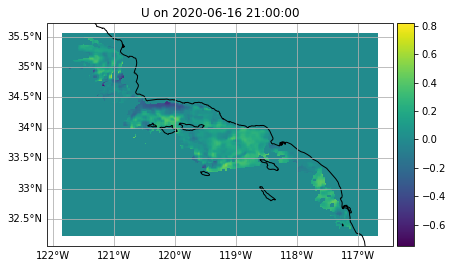

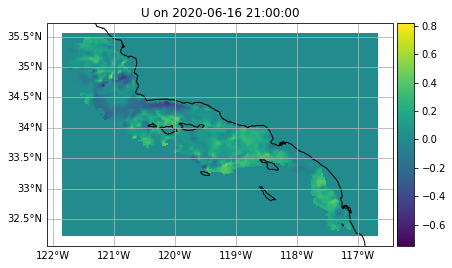

In [26]:
fs.U.show()
fs_interp.U.show()